# Notebook 1 — Data Loading, Cleaning, EDA, and Sentiment Join

**Candidate:** Mohammad_Kamran  
**Date:** 2025-08-29

This notebook:
1. Downloads the datasets from Google Drive.  
2. Loads + cleans Hyperliquid trader data.  
3. Loads the Bitcoin Fear/Greed (daily) dataset.  
4. Joins each trade with the *same-day* sentiment classification.  
5. Produces core KPIs & exploratory charts.  
6. Saves intermediate CSVs to `csv_files/` and figures to `outputs/`.


## 0) Environment & Packages

> Colab tip: Set runtime to **Python 3** (default). No GPU needed.


In [1]:
# If running on Colab, uncomment the next line to ensure all deps are available.
# !pip -q install gdown pandas numpy matplotlib scipy statsmodels scikit-learn plotly


In [2]:
import os, io, sys, json, math, warnings
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# Paths (works on Colab and local)
ROOT = "."
CSV_DIR = os.path.join(ROOT, "csv_files")
OUT_DIR = os.path.join(ROOT, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)


## 1) Download data from Google Drive
Replace the file IDs if they change. Access must be set to "Anyone with the link can view".


In [3]:
# Google Drive file IDs (from assignment prompt)
HYPERLIQUID_FILE_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
FEAR_GREED_FILE_ID  = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

# Use gdown to download (works in Colab). If you're offline, upload manually via Colab sidebar.
try:
    import gdown
    hyperliquid_path = os.path.join(CSV_DIR, "hyperliquid_trades.csv")
    feargreed_path   = os.path.join(CSV_DIR, "fear_greed.csv")
    if not os.path.exists(hyperliquid_path):
        gdown.download(id=HYPERLIQUID_FILE_ID, output=hyperliquid_path, quiet=False)
    if not os.path.exists(feargreed_path):
        gdown.download(id=FEAR_GREED_FILE_ID, output=feargreed_path, quiet=False)
    print("Downloads completed.")
except Exception as e:
    print("If gdown fails, upload the files manually to csv_files/ in Colab.")
    print("Error:", e)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/csv_files/hyperliquid_trades.csv
100%|██████████| 47.5M/47.5M [00:01<00:00, 39.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 56.9MB/s]

Downloads completed.


## 2) Load data
This loader is tolerant to CSV/JSON/Excel. It picks by extension; if you uploaded with a different name, update accordingly.


In [4]:
from pathlib import Path

def smart_read(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)
    ext = path.suffix.lower()
    if ext in [".csv", ".txt"]:
        return pd.read_csv(path)
    if ext in [".json"]:
        return pd.read_json(path)
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path)
    # Fallback assume CSV
    return pd.read_csv(path)

hyperliquid_raw = smart_read(os.path.join(CSV_DIR, "hyperliquid_trades.csv"))
feargreed_raw   = smart_read(os.path.join(CSV_DIR, "fear_greed.csv"))

print("Hyperliquid shape:", hyperliquid_raw.shape)
print("Fear/Greed shape:", feargreed_raw.shape)
display(hyperliquid_raw.head(3))
display(feargreed_raw.head(3))


Hyperliquid shape: (211224, 16)
Fear/Greed shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


## 3) Standardize columns & time
- Normalize column names to snake_case.
- Convert `time` to UTC-aware datetime if present (assumes UNIX ms or ISO).
- Add a `trade_date` column (UTC date) to join with daily sentiment.


In [5]:
def to_snake(s):
    return s.strip().replace(" ", "_").replace("-", "_").lower()

hyper = hyperliquid_raw.copy()
hyper.columns = [to_snake(c) for c in hyper.columns]

# time parsing
def parse_time(x):
    # try int (ms) -> datetime
    try:
        xi = int(x)
        # Heuristic: treat as ms if > 10**12
        if xi > 10**12:
            return datetime.utcfromtimestamp(xi/1000).replace(tzinfo=timezone.utc)
        return datetime.utcfromtimestamp(xi).replace(tzinfo=timezone.utc)
    except Exception:
        # try ISO
        try:
            dt = pd.to_datetime(x, utc=True)
            if isinstance(dt, pd.Timestamp):
                return dt.to_pydatetime()
            return dt
        except Exception:
            return pd.NaT

if "time" in hyper.columns:
    hyper["time_utc"] = hyper["time"].apply(parse_time)
else:
    # fallback: try 'timestamp' or similar
    cand = [c for c in hyper.columns if "time" in c or "stamp" in c]
    if cand:
        hyper["time_utc"] = hyper[cand[0]].apply(parse_time)
    else:
        hyper["time_utc"] = pd.NaT

hyper["trade_date"] = pd.to_datetime(hyper["time_utc"]).dt.floor("D")

# Standardize sentiment columns
fg = feargreed_raw.copy()
fg.columns = [to_snake(c) for c in fg.columns]
# Expected: 'date', 'classification' (Fear/Greed)
if "date" in fg.columns:
    fg["date"] = pd.to_datetime(fg["date"], utc=True).dt.floor("D")
else:
    # try alternate names
    cand = [c for c in fg.columns if "date" in c]
    if cand:
        fg["date"] = pd.to_datetime(fg[cand[0]], utc=True).dt.floor("D")
    else:
        raise ValueError("No date column found in fear/greed dataset")

# Keep only what we need
fg = fg[["date"] + ([c for c in fg.columns if "class" in c] or ["classification"])].copy()
if "classification" not in fg.columns:
    # try to find classification-like column (fear/greed)
    cand = [c for c in fg.columns if "class" in c or "sentiment" in c]
    if cand:
        fg.rename(columns={cand[0]: "classification"}, inplace=True)
    else:
        raise ValueError("No 'classification' column found in sentiment file")

fg["classification"] = fg["classification"].astype(str).str.strip().str.title()  # 'Fear'/'Greed'


## 4) Join trades to sentiment (by date)


In [6]:
df = hyper.merge(fg, left_on="trade_date", right_on="date", how="left", validate="m:1")
df.rename(columns={"classification": "sentiment"}, inplace=True)
print("Merged shape:", df.shape)
display(df.head(5))

# Save merged for reuse
merged_path = os.path.join(CSV_DIR, "trades_with_sentiment.csv")
df.to_csv(merged_path, index=False)
print("Saved:", merged_path)


Merged shape: (211224, 20)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,time_utc,trade_date,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12 00:00:00+00:00,2024-02-12 00:00:00+00:00,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12 00:00:00+00:00,2024-02-12 00:00:00+00:00,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12 00:00:00+00:00,2024-02-12 00:00:00+00:00,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12 00:00:00+00:00,2024-02-12 00:00:00+00:00,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00+00:00,2024-02-12 00:00:00+00:00,2024-02-12 00:00:00+00:00,Greed


Saved: ./csv_files/trades_with_sentiment.csv


## 5) Core KPIs
- **Win rate**: share of trades with `closedPnL > 0`  
- **Avg PnL per trade** and per account  
- **Leverage usage**: mean/median by sentiment  
- **Position sizing**: mean/median `size` by sentiment and side  
- **Risk-adjusted** (rough): PnL per unit notional, and rolling Sharpe proxies


In [7]:
# Normalize key columns if present
for col in ["closedpnl", "closed_pnl"]:
    if col in df.columns:
        df["closed_pnl"] = pd.to_numeric(df[col], errors="coerce")
        break
if "closed_pnl" not in df.columns:
    df["closed_pnl"] = np.nan

for col in ["size"]:
    if col not in df.columns:
        df[col] = np.nan

if "leverage" not in df.columns:
    df["leverage"] = np.nan

if "side" not in df.columns:
    df["side"] = "unknown"

df["win"] = (df["closed_pnl"] > 0).astype(int)

# KPI by sentiment
kpi_sent = df.groupby("sentiment").agg(
    n_trades=("win", "count"),
    win_rate=("win", "mean"),
    avg_pnl=("closed_pnl", "mean"),
    median_pnl=("closed_pnl", "median"),
    avg_size=("size", "mean"),
    med_size=("size", "median"),
    avg_lev=("leverage", "mean"),
    med_lev=("leverage", "median"),
).reset_index()

display(kpi_sent)

kpi_path = os.path.join(CSV_DIR, "kpi_by_sentiment.csv")
kpi_sent.to_csv(kpi_path, index=False)
print("Saved:", kpi_path)


,sentiment,n_trades,win_rate,avg_pnl,median_pnl,avg_size,med_size,avg_lev,med_lev
0,Extreme Fear,5411,0.390501,47.446302,0.0,NaN,NaN,NaN,NaN
1,Extreme Greed,34393,0.458727,73.144030,0.0,NaN,NaN,NaN,NaN
2,Fear,47315,0.387890,56.544720,0.0,NaN,NaN,NaN,NaN
3,Greed,48492,0.403077,35.652184,0.0,NaN,NaN,NaN,NaN
4,Neutral,32246,0.402593,31.746470,0.0,NaN,NaN,NaN,NaN


Saved: ./csv_files/kpi_by_sentiment.csv


## 6) Visualization snippets
Run these cells to produce key plots in `outputs/`.


Saved: ./outputs/winrate_by_sentiment.png


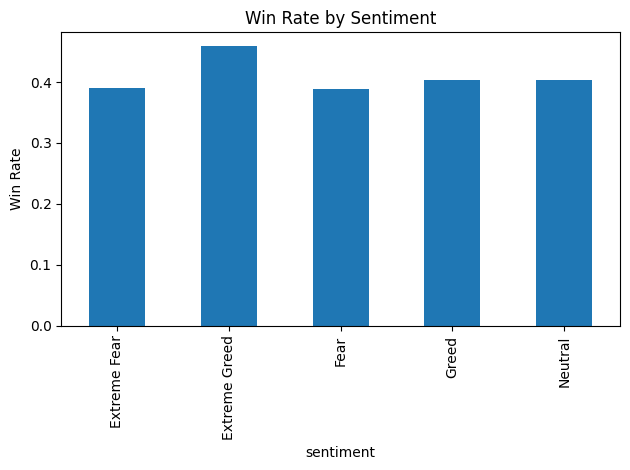

In [8]:
# 6a) Win rate by sentiment
fig = plt.figure()
ax = fig.add_subplot(111)
kpi_sent.plot(x="sentiment", y="win_rate", kind="bar", ax=ax, legend=False)
ax.set_title("Win Rate by Sentiment")
ax.set_ylabel("Win Rate")
fig.tight_layout()
fig_path = os.path.join(OUT_DIR, "winrate_by_sentiment.png")
fig.savefig(fig_path, dpi=160)
print("Saved:", fig_path)


Saved: ./outputs/pnl_hist_by_sentiment.png


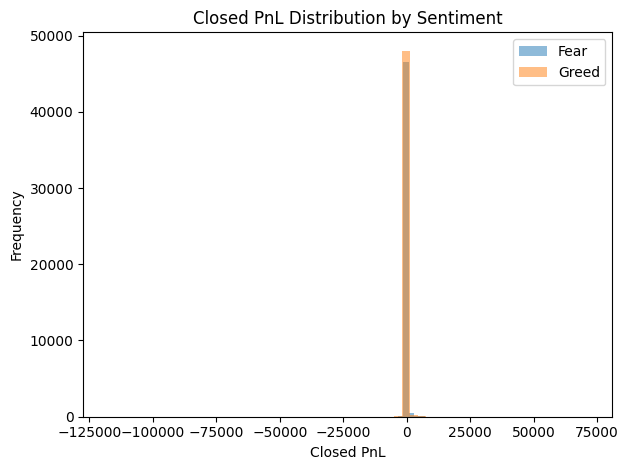

In [9]:
# 6b) PnL distribution by sentiment (basic)
fig = plt.figure()
ax = fig.add_subplot(111)
for snt in ["Fear", "Greed"]:
    subset = df[df["sentiment"]==snt]["closed_pnl"].dropna()
    subset.plot(kind="hist", bins=50, alpha=0.5, ax=ax, label=snt)
ax.set_title("Closed PnL Distribution by Sentiment")
ax.set_xlabel("Closed PnL")
ax.legend()
fig.tight_layout()
fig_path = os.path.join(OUT_DIR, "pnl_hist_by_sentiment.png")
fig.savefig(fig_path, dpi=160)
print("Saved:", fig_path)


Saved: ./outputs/avg_leverage_by_sentiment.png


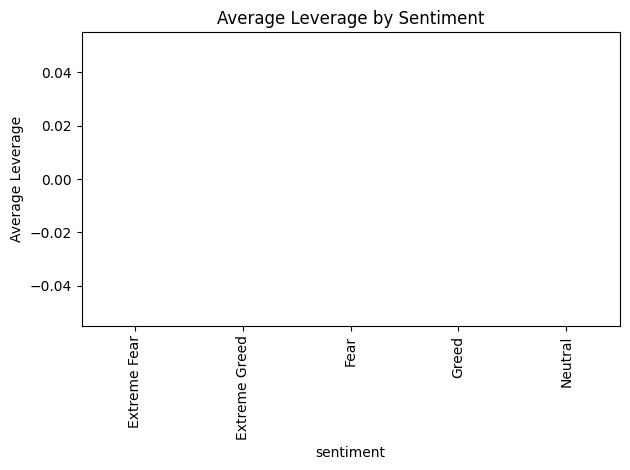

In [10]:
# 6c) Leverage usage by sentiment
fig = plt.figure()
ax = fig.add_subplot(111)
kpi_sent.plot(x="sentiment", y="avg_lev", kind="bar", ax=ax, legend=False)
ax.set_title("Average Leverage by Sentiment")
ax.set_ylabel("Average Leverage")
fig.tight_layout()
fig_path = os.path.join(OUT_DIR, "avg_leverage_by_sentiment.png")
fig.savefig(fig_path, dpi=160)
print("Saved:", fig_path)


## 7) Save per-account KPIs (useful for clustering later)


In [11]:
acct_kpis = df.groupby(["account","sentiment"]).agg(
    n=("win","count"),
    win_rate=("win","mean"),
    avg_pnl=("closed_pnl","mean"),
    avg_size=("size","mean"),
    avg_lev=("leverage","mean")
).reset_index()

acct_kpis_pivot = acct_kpis.pivot_table(index="account", columns="sentiment",
                                        values=["n","win_rate","avg_pnl","avg_size","avg_lev"])
acct_kpis_pivot.columns = [f"{a}_{b}".lower() for a,b in acct_kpis_pivot.columns.to_flat_index()]
acct_kpis_pivot = acct_kpis_pivot.fillna(0.0)

acct_path = os.path.join(CSV_DIR, "account_kpis_wide.csv")
acct_kpis_pivot.to_csv(acct_path)
print("Saved:", acct_path)


Saved: ./csv_files/account_kpis_wide.csv
